In [32]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/autoencoder_experiment_1')

In [22]:
fulldata = np.load('data/fulldata.npy')

In [23]:
len(fulldata)

4328

In [24]:
num_features = fulldata.shape[1] - 1
num_features = 360 # padded

In [25]:
fulldata[:,:-1][0].shape

(338,)

In [26]:
360 / 2 


180.0

## DataLoader

In [27]:
class TheDataSet(Dataset):
    

    def __init__(self):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.fulldata = np.load('data/fulldata.npy')[:,:-1]
        y, x = self.fulldata.shape
        self.fulldata = np.pad(self.fulldata, ((0, 0),(0,360-x)), 'constant', constant_values=(0,0))

    def __len__(self):
        return len(self.fulldata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.fulldata[idx]
       

## AutoEncoder

In [28]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=num_features // 2 , bias=True),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=num_features // 2, bias=True),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=num_features // 2, out_features=num_features // 2, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=num_features, bias=True ),
            #nn.Sigmoid()
            nn.ReLU()
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [29]:
fulldata.shape

(4328, 339)

## Training

In [33]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
#     criterion = nn.MSELoss() # mean square error loss
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    dataset = TheDataSet()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    outputs = []
    losses = []
    for epoch in range(num_epochs):
        for data in train_loader:
            recon = model(data.float())
            loss = criterion(recon, data.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        losses.append(float(loss))
        outputs.append((epoch, data, recon),)
        writer.add_scalar('training loss',
                            loss,
                            epoch * len(train_loader))
    return outputs, losses

In [35]:
model = Autoencoder()
max_epochs = 50
outputs, losses = train(model, num_epochs=max_epochs, batch_size = 32, learning_rate=1e-3)

Epoch:1, Loss:0.1307
Epoch:2, Loss:0.1340
Epoch:3, Loss:0.1301
Epoch:4, Loss:0.1334
Epoch:5, Loss:0.1196
Epoch:6, Loss:0.1117
Epoch:7, Loss:0.1203
Epoch:8, Loss:0.1029
Epoch:9, Loss:0.1346
Epoch:10, Loss:0.1443
Epoch:11, Loss:0.1103
Epoch:12, Loss:0.0909
Epoch:13, Loss:0.0926
Epoch:14, Loss:0.1733
Epoch:15, Loss:0.1068
Epoch:16, Loss:0.1450
Epoch:17, Loss:0.1075
Epoch:18, Loss:0.0915
Epoch:19, Loss:0.1090
Epoch:20, Loss:0.1267
Epoch:21, Loss:0.0881
Epoch:22, Loss:0.1084
Epoch:23, Loss:0.1360
Epoch:24, Loss:0.1190
Epoch:25, Loss:0.0894
Epoch:26, Loss:0.1027
Epoch:27, Loss:0.0997
Epoch:28, Loss:0.1349
Epoch:29, Loss:0.1104
Epoch:30, Loss:0.0812
Epoch:31, Loss:0.1006
Epoch:32, Loss:0.1013
Epoch:33, Loss:0.1067
Epoch:34, Loss:0.1094
Epoch:35, Loss:0.1006
Epoch:36, Loss:0.0930
Epoch:37, Loss:0.0921
Epoch:38, Loss:0.0860
Epoch:39, Loss:0.0937
Epoch:40, Loss:0.1193
Epoch:41, Loss:0.0854
Epoch:42, Loss:0.0673
Epoch:43, Loss:0.0970
Epoch:44, Loss:0.1013
Epoch:45, Loss:0.1085
Epoch:46, Loss:0.08

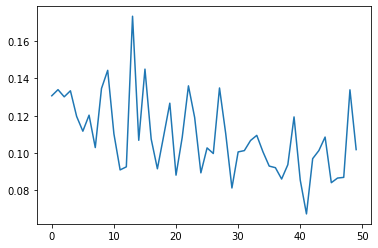

In [36]:
fig = plt.figure()
ax = plt.axes()

# x = np.linspace(0, 10, 1000)
ax.plot(losses);

In [106]:
outputs

[(0,
  tensor([[0.1250, 0.8409, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.8409, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.8409, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1250, 0.8409, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.8409, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.8409, 1.8333,  ..., 0.0000, 0.0000, 0.0000]],
         dtype=torch.float64),
  tensor([[0.4998, 0.5199, 0.4721,  ..., 0.5062, 0.4704, 0.5015],
          [0.4957, 0.5167, 0.4710,  ..., 0.5131, 0.4780, 0.4965],
          [0.4925, 0.5210, 0.4680,  ..., 0.5117, 0.4754, 0.4987],
          ...,
          [0.4924, 0.5213, 0.4700,  ..., 0.5101, 0.4731, 0.4977],
          [0.4996, 0.5150, 0.4704,  ..., 0.5145, 0.4760, 0.5003],
          [0.5011, 0.5165, 0.4772,  ..., 0.5141, 0.4840, 0.4923]],
         grad_fn=<SigmoidBackward>)),
 (1,
  tensor([[0.1250, 0.8409, 2.3333,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.8409, 0.83

In [ ]:
RandomForestClassifier(max_features=5, max_depth=4, n_estimators=90, min_samples_leaf=1, random_state=7))

